# Creating Customer Personas

Let's try to create customer personas, i.e. 'avatars' that represent relevant groups of customers.

First, we want to have a look at the fraction of seniors/youngsters with a partner.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
telco_base_data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [4]:
telco_base_data.groupby(["SeniorCitizen","Partner"]).size().unstack().apply(lambda x: x/x.sum(),axis=1)

Partner,No,Yes
SeniorCitizen,,
0,0.520590,0.479410
1,0.498249,0.501751


The fractions are very similar: around 50% of the people, no matter their age, have a partner.

Then, let's have a look at the fraction of people with dependents given their 'partner' status.

In [5]:
telco_base_data.groupby(["Partner","Dependents"]).size().unstack().apply(lambda x: x/x.sum(),axis=1)

Dependents,No,Yes
Partner,,
No,0.900851,0.099149
Yes,0.485891,0.514109


People without a partner usually do not have dependents, while around half of the people with a partner have dependents: this is what we call a family.

Finally, let's see when Telco customers have dependents, based on both their seniority and partner statuses.

In [6]:
telco_base_data.groupby(["SeniorCitizen","Partner","Dependents"]).size().unstack().apply(lambda x: x/x.sum(),axis=1)

Dependents                   No       Yes
SeniorCitizen Partner                    
0             No       0.885091  0.114909
              Yes      0.411099  0.588901
1             No       0.985940  0.014060
              Yes      0.855148  0.144852

This table shows that youngsters (those with SeniorCitizen = 0) without a partner rarely have dependents; youngsters with a partner have dependents (children) in 59% of the cases.
Seniors (those with SeniorCitizen = 1) without a partner have dependents in only 1.5% of the cases; seniors with a partner have dependents (children?, grandchildren?) in 14% of the cases. This means that, in general, senior Telco customers either have adult children or no children.

Based on this, let's try to calculate the mean values and the modes of the categorical and numerical variables for our four main customer categories. To do this, we have to define our customer personas, who are fictitious characters embodying these four groups:

1. Young Solo: Represents youngsters without a partner and no dependents.
2. Young Family: Represents youngsters with a partner and dependents.
3. Senior Solo: Represents seniors without a partner.
4. Senior Couple: Represents seniors with a partner.

In [7]:
young_solo = telco_base_data[(telco_base_data['SeniorCitizen'] == 0) &
                             (telco_base_data['Partner'] == 'No') &
                             (telco_base_data['Dependents'] == 'No')]

print('Tenure: {:.1f} months'.format(young_solo['tenure'].mean()))
print('Monthly charges: {:.1f}$'.format(young_solo['MonthlyCharges'].mean()))
print('Streaming TV: {}'.format(young_solo['StreamingTV'].mode().values[0]))
print('Internet Service: {}'.format(young_solo['InternetService'].mode().values[0]))


Tenure: 22.9 months
Monthly charges: 60.1$
Streaming TV: No
Internet Service: Fiber optic


In [8]:
young_family = telco_base_data[(telco_base_data['SeniorCitizen'] == 0) &
                               (telco_base_data['Partner'] == 'Yes') &
                               (telco_base_data['Dependents'] == 'Yes')]

print('Tenure: {:.1f} months'.format(young_family['tenure'].mean()))
print('Monthly charges: {:.1f}$'.format(young_family['MonthlyCharges'].mean()))
print('Streaming TV: {}'.format(young_family['StreamingTV'].mode().values[0]))
print('Internet Service: {}'.format(young_family['InternetService'].mode().values[0]))


Tenure: 41.1 months
Monthly charges: 59.9$
Streaming TV: Yes
Internet Service: DSL


In [9]:
senior_solo = telco_base_data[(telco_base_data['SeniorCitizen'] == 1) &
                              (telco_base_data['Partner'] == 'No')]

print('Tenure: {:.1f} months'.format(senior_solo['tenure'].mean()))
print('Monthly charges: {:.1f}$'.format(senior_solo['MonthlyCharges'].mean()))
print('Streaming TV: {}'.format(senior_solo['StreamingTV'].mode().values[0]))
print('Internet Service: {}'.format(senior_solo['InternetService'].mode().values[0]))


Tenure: 25.1 months
Monthly charges: 76.8$
Streaming TV: No
Internet Service: Fiber optic


In [10]:
senior_family = telco_base_data[(telco_base_data['SeniorCitizen'] == 1) &
                                (telco_base_data['Partner'] == 'Yes')]

print('Tenure: {:.1f} months'.format(senior_family['tenure'].mean()))
print('Monthly charges: {:.1f}$'.format(senior_family['MonthlyCharges'].mean()))
print('Streaming TV: {}'.format(senior_family['StreamingTV'].mode().values[0]))
print('Internet Service: {}'.format(senior_family['InternetService'].mode().values[0]))


Tenure: 41.4 months
Monthly charges: 82.8$
Streaming TV: Yes
Internet Service: Fiber optic


In [11]:
from plotly import figure_factory as FF
from plotly.offline import iplot

table_data = [['Customer Persona', 'Demographics', '', 'Tenure [months]', 'Monthly charges', 'Streaming TV', 'Internet', 'Customer value'],
              ['young_solo', 'Young, no partner, no dependents', '', '23', '60$', 'No', 'Fiber', '$\star \star$'],
             ['young_family', 'Young with partner and dependents', '', '41', '60$', 'Yes', 'DSL', '$\star \star \star$'],
             ['senior_solo', 'Senior, no partner', '', '25', '77$', 'No', 'Fiber','$\star \star \star$'],
             ['senior_family', 'Senior with partner', '', '41', '83$', 'Yes', 'Fiber', '$\star \star \star \star$']]

# Initialize a figure with FF.create_table(table_data)
figure = FF.create_table(table_data,height_constant=30)
figure.layout.width=1500

iplot(figure)

It is interesting to see that:

Seniors with partners are those who spend the most. They are also some of the most loyal customers. In light of this, it is easy to say that they are the most valuable customers.
Seniors without a partner spend above the average, but are not so loyal. They are fairly good customers.
Youngsters with partners and dependents are fairly good customers. They spend below the average, but are quite loyal.
Youngsters without partners and dependents are the worst customers. They spend below the average and are not very loyal either.
This is valuable information for Telco, that could help them if they had to start a new marketing campaign.

# Customer Churn Classification

Feature Importance :

In [14]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer,accuracy_score,precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,r2_score
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.svm import SVC, LinearSVC

from xgboost import XGBClassifier
# import optuna
from mlxtend.plotting import plot_decision_regions



In [15]:
telco2 = telco_base_data.copy()

LABELS = telco2.columns

encoder = LabelEncoder()

for col in LABELS:
    if telco2[col].dtype == 'O':
        telco2[col] = encoder.fit_transform(telco2[col])

In [16]:
X = telco2.drop('Churn',axis=1)
y = telco2['Churn']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)

# Random Forest Classifier to find feature importance

In [17]:
random_forest = RandomForestClassifier(random_state=1,max_depth=4)
random_forest.fit(X,y)

importances = pd.DataFrame({'feature':X.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

,importance
feature,
Contract,0.253
tenure,0.165
TechSupport,0.160
OnlineSecurity,0.123
MonthlyCharges,0.074
OnlineBackup,0.051
InternetService,0.048
PaymentMethod,0.032
DeviceProtection,0.032


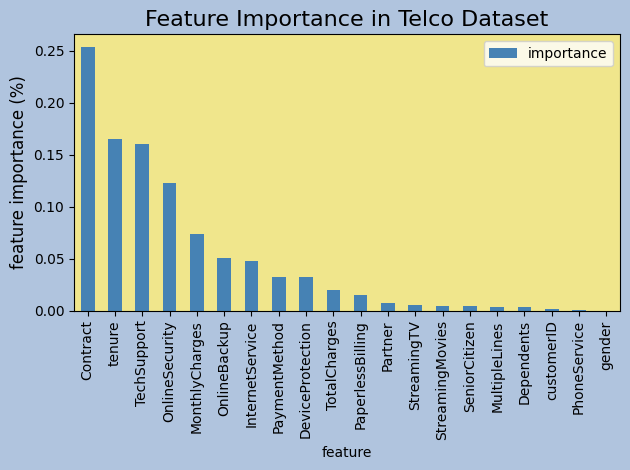

In [18]:
importances.plot.bar(color='steelblue')

plt.ylabel('feature importance (%)',fontsize=12)
plt.title('Feature Importance in Telco Dataset',fontsize=16)

plt.tight_layout()
plt.gcf().patch.set_facecolor('lightsteelblue')
plt.gca().set_facecolor('khaki')
plt.show()

# Linear Support Vector Machine & Support Vector Machine

In [19]:
linear_svc = LinearSVC(max_iter=4000)

linear_svc.fit(X_train,y_train)

# Use the model to predict on test data
linear_svc_test_preds = linear_svc.predict(X_test)

accLinSVC = accuracy_score(y_test,linear_svc_test_preds)
print('accuracy score, linear SVC: {:.3f}'.format(accLinSVC))

accuracy score, linear SVC: 0.708


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [20]:
svc = SVC()

svc.fit(X_train,y_train)

# Use the model to predict on test data
ssvc_test_preds = svc.predict(X_test)

accSVC = accuracy_score(y_test,ssvc_test_preds)
print('accuracy score, SVC: {:.3f}'.format(accSVC))

accuracy score, SVC: 0.738


# Random Forest Classifier

In [21]:
random_forest = RandomForestClassifier()

random_forest.fit(X_train,y_train)

# Use the model to predict on test data
rf_test_preds = random_forest.predict(X_test)

accRF = accuracy_score(y_test,rf_test_preds)
print('accuracy score, random forest: {:.3f}'.format(accRF))

accuracy score, random forest: 0.791


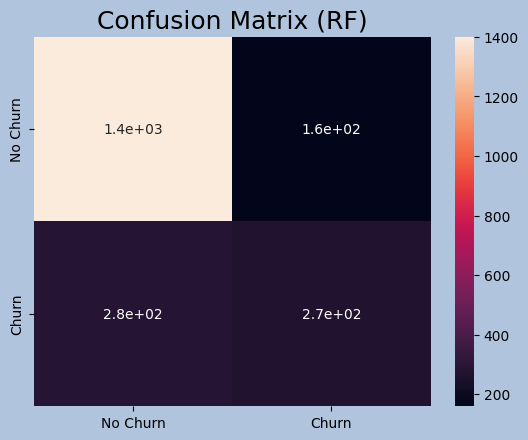

In [22]:
cm = confusion_matrix(y_test,rf_test_preds,labels=random_forest.classes_)

ax = sns.heatmap(cm,annot=True)
ax.xaxis.set_ticklabels(['No Churn','Churn'])
ax.yaxis.set_ticklabels(['No Churn','Churn'])
ax.set_title('Confusion Matrix (RF)',fontsize=18)

plt.gcf().patch.set_facecolor('lightsteelblue')

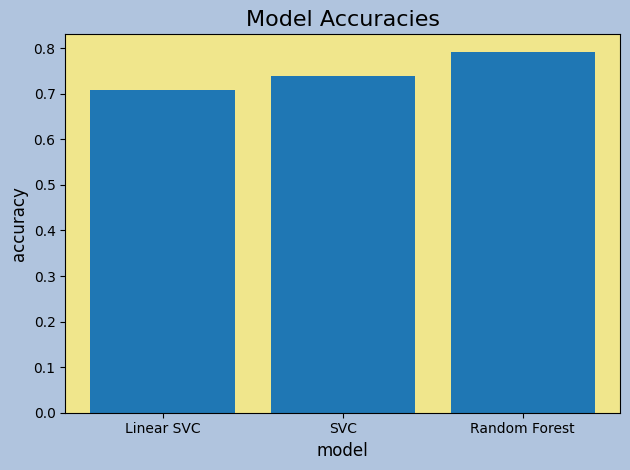

In [23]:
models_accuracy = [accLinSVC,accSVC,accRF]
models = ['Linear SVC','SVC','Random Forest']

plt.bar(models,models_accuracy)
plt.xlabel('model',fontsize=12)
plt.ylabel('accuracy',fontsize=12)
plt.title('Model Accuracies',fontsize=16)

plt.tight_layout()
plt.gcf().patch.set_facecolor('lightsteelblue')
plt.gca().set_facecolor('khaki')
plt.show()

# Churn Rate By Customer Category

The most important features to determine the churn rate are: Contract, tenure, OnlineSecurity and TechSupport.

Let's find out what are the mean values/modes of these features for our main customer groups (i.e. our customer personas).

In [24]:
# Encoding the Churn column
young_solo['Churn'] = encoder.fit_transform(young_solo['Churn'])

print('Contract: {}'.format(young_solo['Contract'].mode()))
print('Online Security: {}'.format(young_solo['OnlineSecurity'].mode()))
print('Tech Support: {}'.format(young_solo['TechSupport'].mode()))
print('Churn: {}'.format(young_solo['Churn'].mean()))

Contract: 0    Month-to-month
Name: Contract, dtype: object
Online Security: 0    No
Name: OnlineSecurity, dtype: object
Tech Support: 0    No
Name: TechSupport, dtype: object
Churn: 0.31151158514159616


In [25]:
# Encoding the Churn column
young_family['Churn'] = encoder.fit_transform(young_family['Churn'])

print('Contract: {}'.format(young_family['Contract'].mode()))
print('Online Security: {}'.format(young_family['OnlineSecurity'].mode()))
print('Tech Support: {}'.format(young_family['TechSupport'].mode()))
print('Churn: {}'.format(young_family['Churn'].mean()))

Contract: 0    Two year
Name: Contract, dtype: object
Online Security: 0    Yes
Name: OnlineSecurity, dtype: object
Tech Support: 0    Yes
Name: TechSupport, dtype: object
Churn: 0.13745498199279713


In [28]:
# Encoding the Churn column
senior_solo['Churn'] = encoder.fit_transform(senior_solo['Churn'])

print('Contract: {}'.format(senior_solo['Contract'].mode()))
print('Online Security: {}'.format(senior_solo['OnlineSecurity'].mode()))
print('Tech Support: {}'.format(senior_solo['TechSupport'].mode()))
print('Churn: {}'.format(senior_solo['Churn'].mean()))

Contract: 0    Month-to-month
Name: Contract, dtype: object
Online Security: 0    No
Name: OnlineSecurity, dtype: object
Tech Support: 0    No
Name: TechSupport, dtype: object
Churn: 0.48857644991212656


In [30]:
# Encoding the Churn column
senior_family['Churn'] = encoder.fit_transform(senior_family['Churn'])

print('Contract: {}'.format(senior_family['Contract'].mode()))
print('Online Security: {}'.format(senior_family['OnlineSecurity'].mode()))
print('Tech Support: {}'.format(senior_family['TechSupport'].mode()))
print('Churn: {}'.format(senior_family['Churn'].mean()))

Contract: 0    Month-to-month
Name: Contract, dtype: object
Online Security: 0    No
Name: OnlineSecurity, dtype: object
Tech Support: 0    No
Name: TechSupport, dtype: object
Churn: 0.34554973821989526


In [31]:
table_data = [['Customer Persona', 'Demographics', '', 'Contract', 'Tenure [months]', 'Online Security', 'Tech Support', 'Expected Churn', 'Customer value'],
             ['young_solo', 'Young, no partner, no dependents', '', 'Month-to-month', '23', 'No', 'No', '0.31', '$\star \star$'],
             ['young_family', 'Young with partner and dependents', '', 'Two Year', '41', 'Yes', 'Yes', '0.14', '$\star \star \star \star$'],
             ['senior_solo', 'Senior, no partner', '', 'Month-to-month', '25', 'No', 'No', '0.49','$\star \star \star$'],
             ['senior_family', 'Senior with partner', '', 'Month-to-month', '41', 'No', 'No', '0.35', '$\star \star \star \star$']]

# Initialize a figure with FF.create_table(table_data)
figure = FF.create_table(table_data,height_constant=30)
figure.layout.width=1500

iplot(figure)

The value of Expected Churn ranges between 0 and 1, where values close to 0 stand for lower churn rates.

This table shows that 'Mike' is expected to be the most loyal customer with the longest type of contract. This is why I am raising his customer value from the previous evaluation of  
3 star to 4 star.